In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import LabelBinarizer, RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import accuracy_score

from sklearn_pandas import DataFrameMapper, cross_val_score

In [2]:
def rename_columns(df: pd.DataFrame) -> pd.DataFrame:
    columns_mapping = {
        "PassengerId": "passenger_id",
        "Survived": "survived",
        "Pclass": "ticket_class",
        "Name": "full_name",
        "Sex": "sex",
        "Age": "age",
        "Ticket": "ticket_number",
        "Fare": "ticket_price",
        "Embarked": "embark_place",
        "SibSp": "sibling_spouses_onboard",
        "Parch" : "parents_children_onboard",
        "Cabin": "cabin_code",
    }
    
    return df.rename(columns=columns_mapping)
    

def drop_columns(df: pd.DataFrame) -> pd.DataFrame:
    columns_to_drop = ["cabin_code"]
    return df.drop(columns_to_drop, axis=1)

def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    df["family_onboard"] = df["sibling_spouses_onboard"] + df["parents_children_onboard"]
    return df

def null_processing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.dropna(subset=["embark_place"])
    
    df.loc[:, "age"] = df["age"].fillna(df["age"].median())
    
    return df

def pre_process(df: pd.DataFrame) -> pd.DataFrame:
    df = rename_columns(df)
    df = drop_columns(df)
    df = feature_engineering(df)
    df = null_processing(df)
    
    return df
    

In [3]:
data = pd.read_csv("data/train.csv")
data = pre_process(data)

train_data, test_data = train_test_split(data)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

train_data.head()

/home/giuliano/kaggle/kaggle-titanic/venv/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,passenger_id,survived,ticket_class,full_name,sex,age,sibling_spouses_onboard,parents_children_onboard,ticket_number,ticket_price,embark_place,family_onboard
0,859,1,3,"Baclini, Mrs. Solomon (Latifa Qurban)",female,24.0,0,3,2666,19.2583,C,3
1,603,0,1,"Harrington, Mr. Charles H",male,28.0,0,0,113796,42.4000,S,0
2,675,0,2,"Watson, Mr. Ennis Hastings",male,28.0,0,0,239856,0.0000,S,0
3,454,1,1,"Goldenberg, Mr. Samuel L",male,49.0,1,0,17453,89.1042,C,1
4,197,0,3,"Mernagh, Mr. Robert",male,28.0,0,0,368703,7.7500,Q,0


In [32]:
train_data.dtypes

passenger_id                  int64
survived                      int64
ticket_class                  int64
full_name                    object
sex                          object
age                         float64
sibling_spouses_onboard       int64
parents_children_onboard      int64
ticket_number                object
ticket_price                float64
embark_place                 object
family_onboard                int64
dtype: object

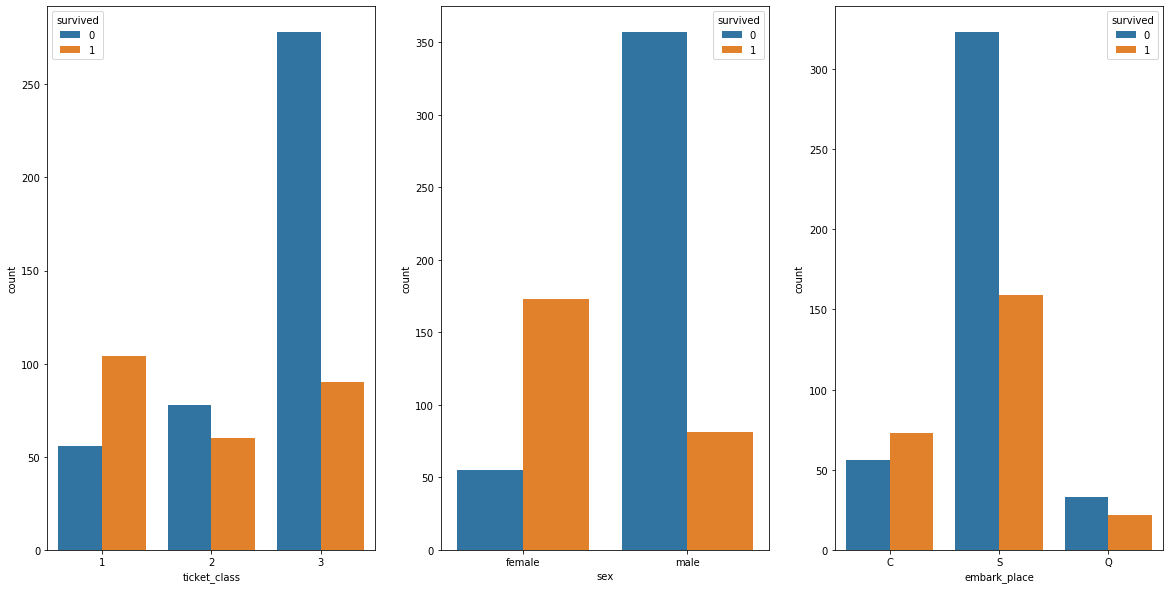

In [19]:
cat_columns = ["ticket_class", "sex", "embark_place"]
_, axs = plt.subplots(ncols=len(cat_columns), figsize=(20, 10))

for i, column in enumerate(cat_columns):
    sns.countplot(x=column, hue="survived", data=train_data, ax=axs[i])

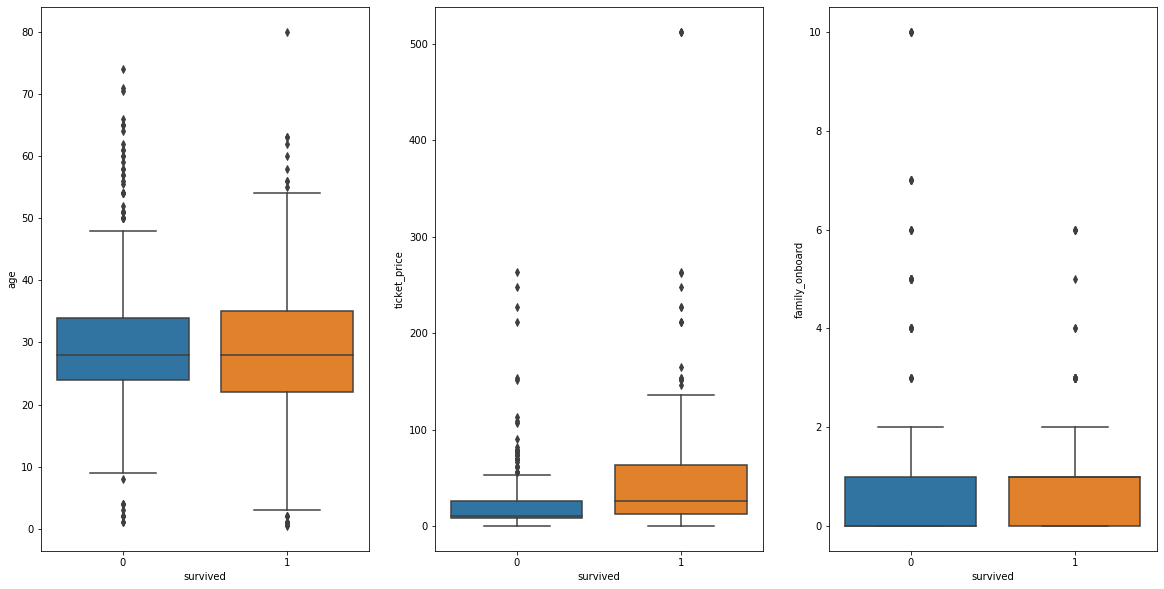

In [20]:
family_onboardnum_columns = ["age", "ticket_price", "family_onboard"]

_, axs = plt.subplots(ncols=len(num_columns), figsize=(20, 10))

for i, column in enumerate(num_columns):
    sns.boxplot(x="survived", y=column, data=train_data, ax=axs[i])

In [11]:
train_data.isna().mean()

passenger_id                0.0
survived                    0.0
ticket_class                0.0
full_name                   0.0
sex                         0.0
age                         0.0
sibling_spouses_onboard     0.0
parents_children_onboard    0.0
ticket_number               0.0
ticket_price                0.0
embark_place                0.0
family_onboard              0.0
dtype: float64

In [4]:
features_to_use = ["ticket_class", "sex", "age", "sibling_spouses_onboard", "parents_children_onboard", "ticket_price", "embark_place", "family_onboard"]

X_train = train_data[features_to_use]
X_test = test_data[features_to_use]

y_train = train_data.survived.values
y_test = test_data.survived.values

mapper = DataFrameMapper([
    ("ticket_class", None),
    ("sex", LabelBinarizer()),
    (["age"], None),
    ("sibling_spouses_onboard", None),
    ("parents_children_onboard", None),
    (["ticket_price"], [SimpleImputer(strategy="median")]),
    ("embark_place", LabelBinarizer()),
    ("family_onboard", None),
])

mapper.fit(X_train)

X_train = mapper.transform(X_train)
X_test = mapper.transform(X_test)

In [5]:
logistic_reg_model = LogisticRegression()
logistic_reg_model.fit(X_train, y_train)

pred = logistic_reg_model.predict(X_test)

print(logistic_reg_model.score(X_test, y_test))

0.7847533632286996


/home/giuliano/kaggle/kaggle-titanic/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [ ]:
random_forest_model = RandomForestClassifier()

parameters = dict(n_estimators=np.arange(1, 1000), max_depth=np.arange(0, 1000), min_samples_split=np.arange(0, 1000), )
grid_search_cv = GridSearchCV(random_forest_model, parameters, cv=5, n_jobs=-1)
grid_search_cv.fit(X_train, y_train)

print(grid_search_cv.score(X_test, y_test))

### Validation

In [8]:
validation_data = pd.read_csv("data/test.csv")
validation_data = pre_process(validation_data)
validation_X = validation_data[features_to_use]
validation_X = mapper.transform(validation_X)
validation_data["pred"] = random_forest_model.predict(validation_X)

In [9]:
(validation_data[["passenger_id", "pred"]]
 .rename(columns={"passenger_id": "PassengerId", "pred": "Survived"})
 .to_csv("submissions/sub_3.csv", index=False))